<a href="https://colab.research.google.com/github/hafnailmy-bip/pertemuan2/blob/main/PCD_Pratikum_2_Pertemuan_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload gambar...


Saving Foto Tugas Citra Digital.jpeg to Foto Tugas Citra Digital.jpeg


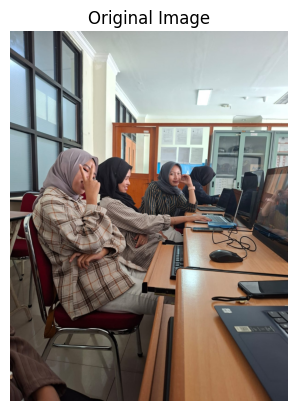


===== COLOR MODEL ANALYSIS =====

Application: skin_detection
Best Model: RGB
RGB     : 135.2398
GRAY    : 67.7503
HSV     : 122.0432
YCrCb   : 22.9196
LAB     : 18.5774

Application: shadow_removal
Best Model: HSV
RGB     : 0.0002
GRAY    : 0.0002
HSV     : 0.0004
YCrCb   : 0.0002
LAB     : 0.0002

Application: text_extraction
Best Model: LAB
RGB     : 20.6756
GRAY    : 20.4224
HSV     : 5.2356
YCrCb   : 20.4224
LAB     : 21.0270

Application: object_detection
Best Model: RGB
RGB     : 68.8465
GRAY    : 67.7503
HSV     : 56.9446
YCrCb   : 30.2233
LAB     : 29.3886


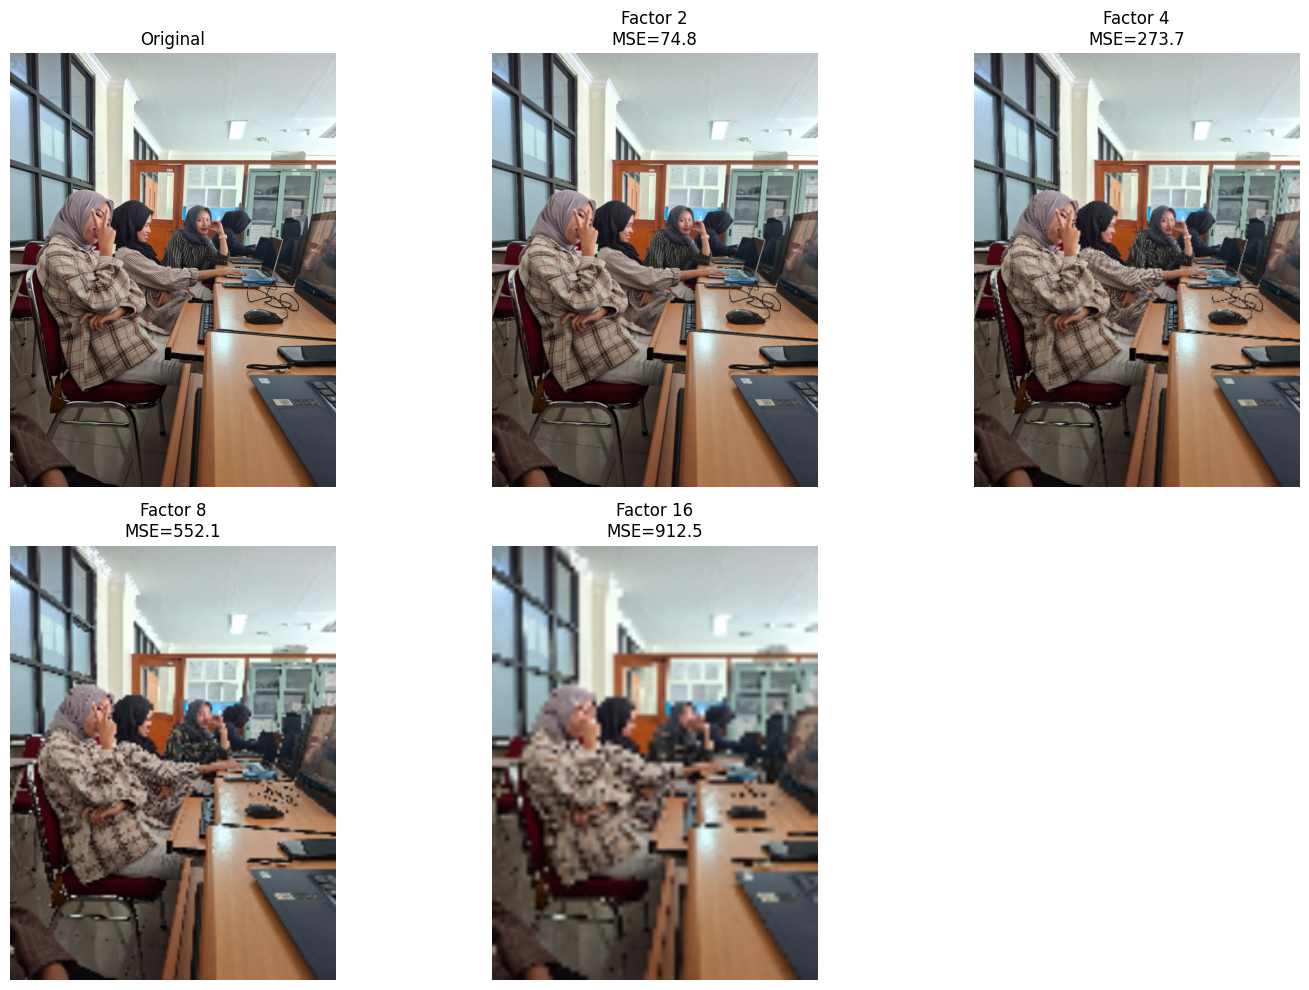


===== ALIASING ERROR =====
Factor 2 -> Error: 74.82
Factor 4 -> Error: 273.68
Factor 8 -> Error: 552.07
Factor 16 -> Error: 912.55


In [1]:
# ==========================================================
# IMAGE COLOR MODEL ANALYSIS + ALIASING SIMULATION
# Ready for Google Colab
# ==========================================================

# Install dependencies (colab biasanya sudah ada, tapi biar aman)
!pip -q install opencv-python scikit-image matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from skimage.metrics import mean_squared_error as mse

# ==========================================================
# Upload Image
# ==========================================================
print("Upload gambar...")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()

# ==========================================================
# COLOR MODEL ANALYSIS
# ==========================================================
def convert_color_spaces(image):
    models = {}
    models['RGB'] = image.copy()
    models['GRAY'] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    models['HSV'] = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    models['YCrCb'] = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    models['LAB'] = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    return models

def contrast_metric(channel):
    return np.std(channel)

def edge_strength(channel):
    edges = cv2.Canny(channel.astype(np.uint8), 50, 150)
    return np.mean(edges)

def analyze_color_model_suitability(image, application):

    models = convert_color_spaces(image)
    scores = {}

    for name, img in models.items():

        if application == 'skin_detection':
            if len(img.shape) == 3:
                score = contrast_metric(img[:,:,1]) + contrast_metric(img[:,:,2])
            else:
                score = contrast_metric(img)

        elif application == 'shadow_removal':
            if name in ['YCrCb', 'LAB']:
                channel = img[:,:,0]
            else:
                channel = img if len(img.shape)==2 else img[:,:,0]
            score = 1 / (np.var(channel)+1e-5)

        elif application == 'text_extraction':
            channel = img if len(img.shape)==2 else img[:,:,0]
            score = edge_strength(channel)

        elif application == 'object_detection':
            if len(img.shape) == 3:
                score = np.mean([contrast_metric(img[:,:,i]) for i in range(3)])
            else:
                score = contrast_metric(img)

        scores[name] = score

    best_model = max(scores, key=scores.get)
    return best_model, scores

# ==========================================================
# Run Analysis
# ==========================================================
applications = ['skin_detection','shadow_removal','text_extraction','object_detection']

print("\n===== COLOR MODEL ANALYSIS =====")
for app in applications:
    best, scores = analyze_color_model_suitability(img, app)

    print(f"\nApplication: {app}")
    print("Best Model:", best)
    for k,v in scores.items():
        print(f"{k:7s} : {v:.4f}")

# ==========================================================
# ALIASING SIMULATION
# ==========================================================
def downsample(image, factor):
    h, w = image.shape[:2]
    return cv2.resize(image, (w//factor, h//factor), interpolation=cv2.INTER_NEAREST)

def upsample(image, original_shape):
    return cv2.resize(image, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_LINEAR)

def simulate_image_aliasing(image, factors):

    results = {}

    for f in factors:
        small = downsample(image, f)
        restored = upsample(small, image.shape[:2])
        error = mse(image, restored)

        results[f] = (small, restored, error)

    return results

# ==========================================================
# Run Aliasing Simulation
# ==========================================================
factors = [2,4,8,16]
results = simulate_image_aliasing(img_rgb, factors)

plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

i=2
for f,(small,restored,error) in results.items():
    plt.subplot(2,3,i)
    plt.imshow(restored)
    plt.title(f"Factor {f}\nMSE={error:.1f}")
    plt.axis("off")
    i+=1

plt.tight_layout()
plt.show()

print("\n===== ALIASING ERROR =====")
for f,data in results.items():
    print(f"Factor {f} -> Error: {data[2]:.2f}")